# Quantum Repeater Design - Purification Strategy Test

## Heralded Quantum Repeater

### Components

* QGen - perform entangled photons/qubits generation
* QSwap - performing quantum entanglement swapping
* Alice - represents sender
* Bob - represents destination/recipient
* QMem - stores qubits awaiting swapping protocol

In [158]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import IBMQ, transpile, execute
from qiskit.result import Counts, marginal_counts
from qiskit.visualization import array_to_latex, plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit.quantum_info import random_statevector, Statevector, state_fidelity, DensityMatrix
from qiskit.providers.aer import StatevectorSimulator, QasmSimulator, AerSimulator
from qiskit.circuit import Instruction, Gate
from qiskit.circuit.library import RXGate
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
from qiskit.quantum_info.analysis import hellinger_fidelity

In [159]:
def get_device_noise_model() -> (AerSimulator, NoiseModel):
    provider = IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')

    backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                       not b.configuration().simulator and b.status().operational==True))
    backend = AerSimulator.from_backend(backend)

    noise_model = NoiseModel.from_backend(backend)
    return backend, noise_model

In [160]:
SHOTS = 10000
ITERATIONS_TO_AVG = 20
backend, noise_model = get_device_noise_model()

ibmqfactory.load_account:WARNING:2022-11-16 23:03:01,857: Credentials are already in use. The existing account in the session will be replaced.


In [161]:
print("Backend:\n", backend)
print("\nNoise Model:\n", noise_model)

Backend:
 aer_simulator(ibmq_quito)

Noise Model:
 NoiseModel:
  Basis gates: ['cx', 'for_loop', 'id', 'if_else', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_clifford', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_matrix_product_state', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'save_superop', 'save_unitary', 'set_density_matrix', 'set_matrix_product_state', 'set_stabilizer', 'set_statevector', 'set_superop', 'set_unitary', 'superop', 'sx', 'while_loop', 'x']
  Instructions with noise: ['measure', 'x', 'reset', 'cx', 'id', 'sx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (3, 4)), ('cx', (4, 3)), 

In [162]:
class QuantumCircuitOperations:
    def __init__(self, barrier: bool = False):
        self.barrier = barrier
    
    def create_random_statevector(self, dimensions: int) -> Statevector:
        return random_statevector(dimensions)
    
    def create_bell_pairs(self, qc: QuantumCircuit, regs: list) -> None:
        if self.barrier: qc.barrier()
        for reg in regs:
            for q in range(reg.size):
                if q % 2 == 0:
                    qc.h(reg[q])
                    qc.cx(reg[q], reg[q + 1])
    
    def bell_state_operation(self, qc: QuantumCircuit, a: list = [QuantumRegister, QuantumRegister]) -> None:
        if self.barrier: qc.barrier()
        qc.cx(a[0], a[1])
        qc.h(a[0])
    
    def bell_state_measurement(self, qc: QuantumCircuit, a: list = [QuantumRegister, QuantumRegister]) -> None:
        if self.barrier: qc.barrier()
        qc.measure(a[0], 0)
        qc.measure(a[1], 1)
    
    def pauli_correction_operation(self, qc: QuantumCircuit, b: QuantumRegister, bsm_z: ClassicalRegister, bsm_x: ClassicalRegister) -> None:
        # Apply the gates if the registers are in the state '1'
        if self.barrier: qc.barrier()
        qc.x(b).c_if(bsm_x, 1)
        qc.z(b).c_if(bsm_z, 1)

In [163]:
class QuantumVisualizations:
    def display_statevector_as_array(self, psi: Statevector) -> None:
        display(array_to_latex(psi, prefix="|\\psi\\rangle = "))
    
    def display_bloch_statevector(self, psi: Statevector):
        return plot_bloch_multivector(psi)

In [164]:
class QuantumNativeSimulations:
    def statevector_sim(self, qc: QuantumCircuit) -> Statevector:
        # returns the circuit statevector
        state_sim: StatevectorSimulator = StatevectorSimulator()
        return state_sim.run(transpile(qc, state_sim)).result().get_statevector()
    
    def qasm_sim(self, qc: QuantumCircuit) -> Counts:
        qasm_sim: QasmSimulator = QasmSimulator()
        # result = execute(qc, qasm_sim, shots=10240, optimization_level=3).result()
        result = execute(qc, qasm_sim, shots=10240, optimization_level=3,noise_model=noise_model).result()
        return result.get_counts()
        # return qasm_sim.run(transpile(qc, qasm_sim), shots=10240).result().get_counts()

In [165]:
def get_count_from_duplicate_circuit(c: QuantumCircuit, a: QuantumRegister, b: QuantumRegister) -> (QuantumCircuit,Counts):
    qcn: QuantumCircuit = c.copy(name="qcn")
    qcn.barrier()
    qcn.measure(a, 0)
    qcn.measure(b, 1)
    qcn_counts: Counts = qns.qasm_sim(qcn)
    return (qcn, qcn_counts)

In [166]:
def get_fidelities_dict(dc: dict) -> dict:
    # compare fidelities
    dictlen: int = len(dc)
    dict_fids = {}

    for i in range(dictlen):
        if i == dictlen - 1:
            break
        cur: str = list(dc.keys())[0]
        nxt: str = list(dc.keys())[i + 1]
        fidelity: float = hellinger_fidelity(dc[cur], dc[nxt])
        f = "F("+cur+","+nxt+")"
        dict_fids[f] = fidelity
    return dict_fids

In [167]:
def full_deutsch_purification() -> Gate:
    c = QuantumCircuit(6, name="Full Deutsch")
    c.append(RXGate(np.pi/2), [0])
    c.append(RXGate(-np.pi/2), [4])
    c.append(RXGate(np.pi/2), [2])
    c.append(RXGate(-np.pi/2), [3])
    c.append(RXGate(-np.pi/2), [1])
    c.append(RXGate(np.pi/2), [5])

    c.cx(0, 2)
    c.cx(0, 4)

    c.cx(1, 5)
    c.cx(1, 3)
    c.to_gate(label="Full Deutsch")
    return c

def quad_deutsch_purification(n: int) -> Gate:
    c = QuantumCircuit(n, name="Quad Deutsch")
    c.append(RXGate(np.pi/2), [0])
    c.append(RXGate(-np.pi/2), [1])
    c.append(RXGate(np.pi/2), [2])
    c.append(RXGate(-np.pi/2), [3])
    
    c.cx(0, 2)
    c.cx(1, 3)
    
    c.to_gate(label="Quad Deutsch")
    return c

def duo_deutsch_purification(n: int) -> Gate:
    c = QuantumCircuit(n, name="Duo Deutsch")
    c.append(RXGate(np.pi/2), [0])
    c.append(RXGate(-np.pi/2), [1])
    
    c.to_gate(label="Duo Deutsch")
    return c

In [168]:
qco: QuantumCircuitOperations = QuantumCircuitOperations(True)
qns: QuantumNativeSimulations = QuantumNativeSimulations()
qv: QuantumVisualizations = QuantumVisualizations()

dict_counts: dict= {}

In [169]:
def fidelity_analysis(strategy: str = None) -> (QuantumCircuit, Counts) :
    alice: QuantumRegister = QuantumRegister(2, "alice")
    charlie: QuantumRegister = QuantumRegister(2, "charlie")
    bob: QuantumRegister = QuantumRegister(2, "bob")

    bsm_z: ClassicalRegister = ClassicalRegister(1, "bsm_zresult")
    bsm_x: ClassicalRegister = ClassicalRegister(1, "bsm_xresult")

    # coz: ClassicalRegister = ClassicalRegister(1, "coz")
    # cox: ClassicalRegister = ClassicalRegister(1, "cox")

    qc: QuantumCircuit = QuantumCircuit(alice, charlie, bob, bsm_z, bsm_x)#, coz, cox)
    
    dict_counts.clear()
    
    psi: Statevector = qco.create_random_statevector(2)
    init_instruction: Initialize = Initialize(psi)
    init_instruction.label = "init instruction"
    qc.append(init_instruction, [alice[0]])
    # qc.append(init_instruction, [bob[1]])
    
    qco.create_bell_pairs(qc, [alice, charlie, bob])
    # purification after bell pair creation
    if strategy == "abpc" or strategy == "cust":
        qc.append( quad_deutsch_purification(4), [alice[0], alice[1], charlie[0], charlie[1]] )
    # count after bell pair creation
    qc_abpc, count_abpc = get_count_from_duplicate_circuit(qc, alice[0], alice[1])
    dict_counts["abpc"] = count_abpc
    
    # count after entanglement after distribution/transmission
    qc_dist, count_dist = get_count_from_duplicate_circuit(qc, alice[0], alice[1])
    dict_counts["dist"] = count_dist
    
    # Swap Protocol Stage 1
    if strategy == "swapalt":
        qc.append( quad_deutsch_purification(4), [alice[0], alice[1], charlie[0], charlie[1]] )
    qco.bell_state_operation(qc, [alice[1], charlie[0]])
    qco.bell_state_measurement(qc, [alice[1], charlie[0]])
    qco.pauli_correction_operation(qc, charlie[1], bsm_z, bsm_x)
    # purification after first swap protocol
    if strategy == "aswap1" or strategy == "swap" or strategy == "swapalt" or strategy == "cust":
        qc.append( quad_deutsch_purification(4), [alice[0], charlie[1], bob[0], bob[1]] )
        
    if strategy == "swaploop":
        for i in range(3):
            qc.append( quad_deutsch_purification(4), [alice[0], charlie[1], bob[0], bob[1]] )
        
    # count after first stage swap
    qc_aswap, count_aswap = get_count_from_duplicate_circuit(qc, alice[0], charlie[1])
    dict_counts["aswap1"] = count_aswap

    # Swap Protocol Stage 2
    if strategy == "swapalt":
        qc.append( quad_deutsch_purification(4), [alice[0], charlie[1], bob[0], bob[1]] )
    qco.bell_state_operation(qc, [charlie[1], bob[0]])
    qco.bell_state_measurement(qc, [charlie[1], bob[0]])
    qco.pauli_correction_operation(qc, bob[1], bsm_z, bsm_x)
    # purification after second swap protocol
    if strategy == "aswap2" or strategy == "swap" or strategy == "swapalt" or strategy == "cust":
        qc.append( duo_deutsch_purification(2), [alice[0], bob[1]] )
        
    if strategy == "swaploop":
        for i in range(3):
            qc.append( duo_deutsch_purification(2), [alice[0], bob[1]] )
        
    # count after second stage swap
    qc_aswap, count_aswap = get_count_from_duplicate_circuit(qc, alice[0], bob[1])
    dict_counts["aswap2"] = count_aswap
    
    qc.barrier()
    qc.cx(alice[0], bob[1])
    qc.h(alice[0])
    
    # 
    inverse_init_instruction: Initialize = init_instruction.gates_to_uncompute()
    qc.append(inverse_init_instruction, [alice[0]])
    # qc.append(inverse_init_instruction, [bob[1]])
    
    qc.barrier()
    qc.measure(alice[0], bsm_z)
    qc.measure(bob[1], bsm_x)

    counts: Counts = qns.qasm_sim(qc)
    dict_counts["count_end"] = counts
    
    return (qc, counts)

### Without Purification - Null Purification

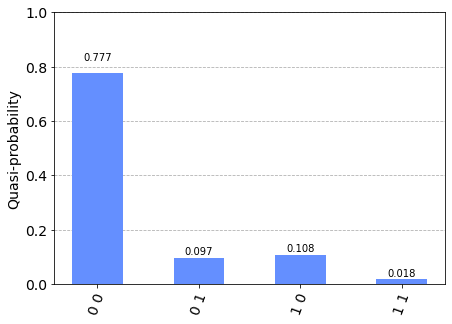

In [170]:
d = []
for i in range(ITERATIONS_TO_AVG):
    circ, counts = fidelity_analysis()
    d.append(counts)

counts = dict( pd.DataFrame(d).mean() )

dict_fids_wp: dict = get_fidelities_dict(dict_counts)

graph = plot_histogram(counts)#, title="Measurement Results of Alice and Bob's Qubits After Quantum Repeater Protocol")

dx = graph.axes[0]
dx.set_ylim(0, 1)

display( graph )

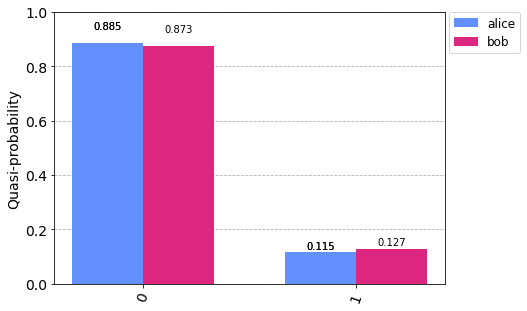

In [171]:
qubit_counts: list = [marginal_counts(counts, [qubit]) for qubit in range(0, 2)]
legend: list = ["alice", "bob"]
graph = plot_histogram(qubit_counts, legend=legend)#, title="Verification of Entanglement Swapping between Alice and Bob")
dx = graph.axes[0]
dx.set_ylim(0, 1)
display( graph )

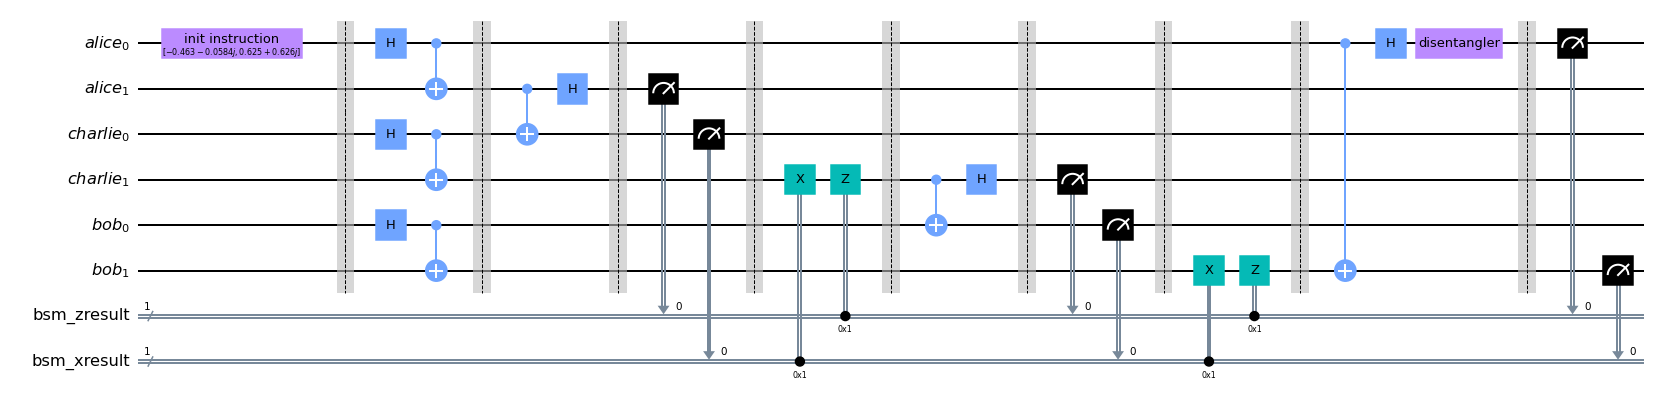

In [172]:
circ.draw("mpl", fold=-1)

### With Purification After Bell-pair production - Post Bell_pair pruduction purification

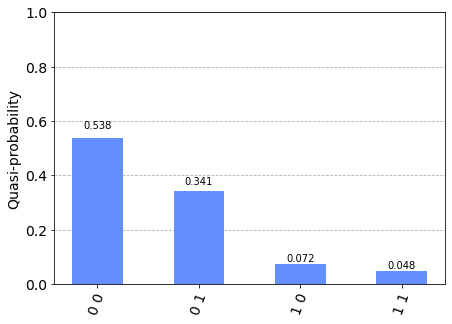

In [173]:
# circ, counts = fidelity_analysis("abpc")
# # dict_counts_wp: dict = dict_counts
# dict_fids_abpc: dict = get_fidelities_dict(dict_counts)
# plot_histogram(counts)#, title="Measurement Results of Alice and Bob's Qubits After Quantum Repeater Protocol")

d = []
for i in range(ITERATIONS_TO_AVG):
    circ, counts = fidelity_analysis("abpc")
    d.append(counts)

counts = dict( pd.DataFrame(d).mean() )

dict_fids_abpc: dict = get_fidelities_dict(dict_counts)

graph = plot_histogram(counts)

dx = graph.axes[0]
dx.set_ylim(0, 1)

display( graph )

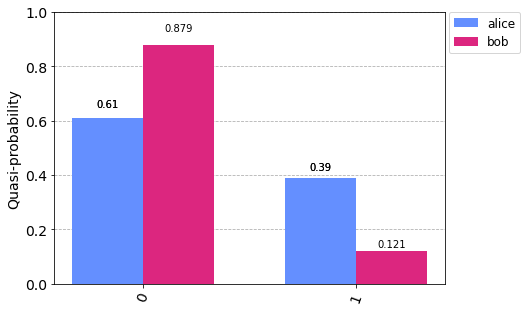

In [174]:
qubit_counts: list = [marginal_counts(counts, [qubit]) for qubit in range(0, 2)]
legend: list = ["alice", "bob"]
graph = plot_histogram(qubit_counts, legend=legend)#, title="Verification of Entanglement Swapping between Alice and Bob")
dx = graph.axes[0]
dx.set_ylim(0, 1)
display( graph )

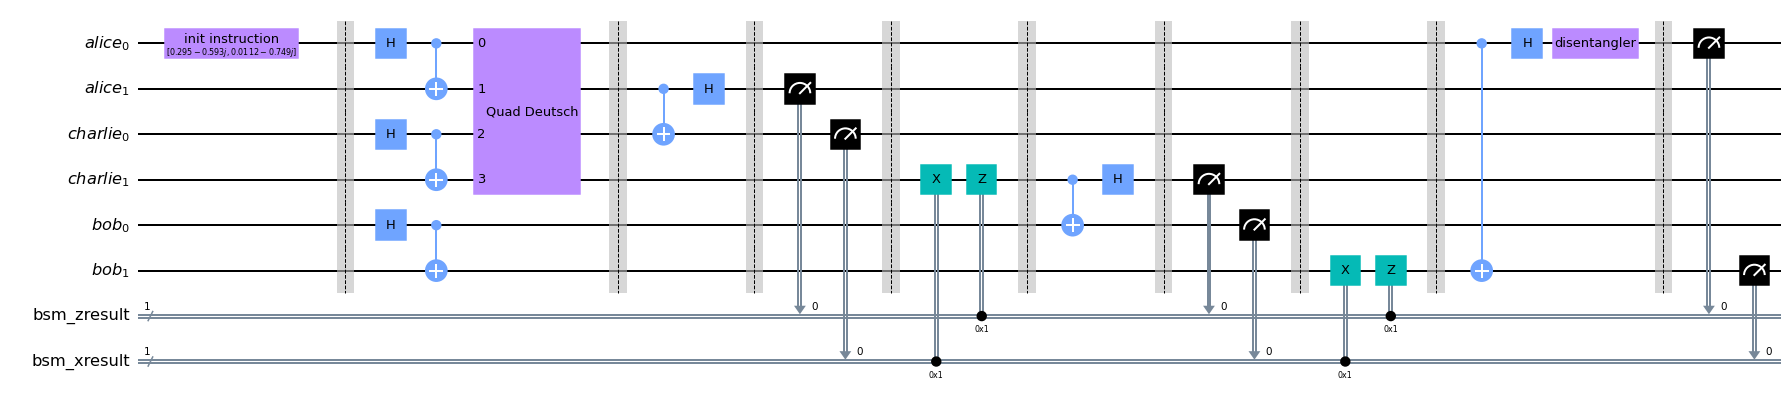

In [175]:
circ.draw("mpl", fold=-1)

### With Purification After Every Swap - Post Swap Purification

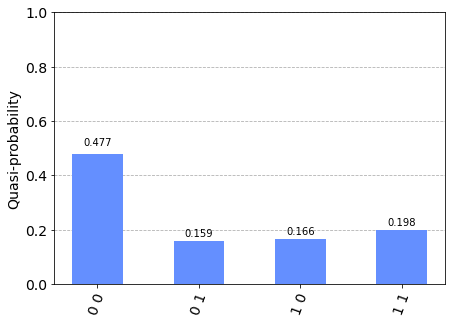

In [176]:
d = []
for i in range(ITERATIONS_TO_AVG):
    circ, counts = fidelity_analysis("swap")
    d.append(counts)

counts = dict( pd.DataFrame(d).mean() )

dict_fids_swap: dict = get_fidelities_dict(dict_counts)

graph = plot_histogram(counts)#, title="Measurement Results of Alice and Bob's Qubits After Quantum Repeater Protocol")

dx = graph.axes[0]
dx.set_ylim(0, 1)

display( graph )

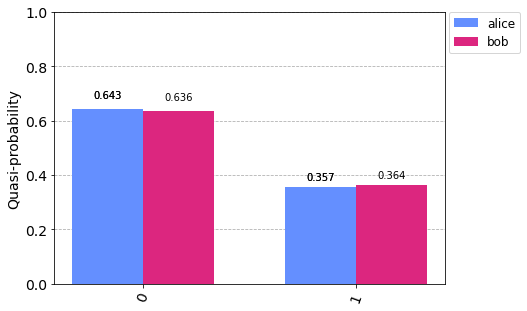

In [177]:
qubit_counts: list = [marginal_counts(counts, [qubit]) for qubit in range(0, 2)]
legend: list = ["alice", "bob"]
graph = plot_histogram(qubit_counts, legend=legend)#, title="Verification of Entanglement Swapping between Alice and Bob")
dx = graph.axes[0]
dx.set_ylim(0, 1)
display( graph )

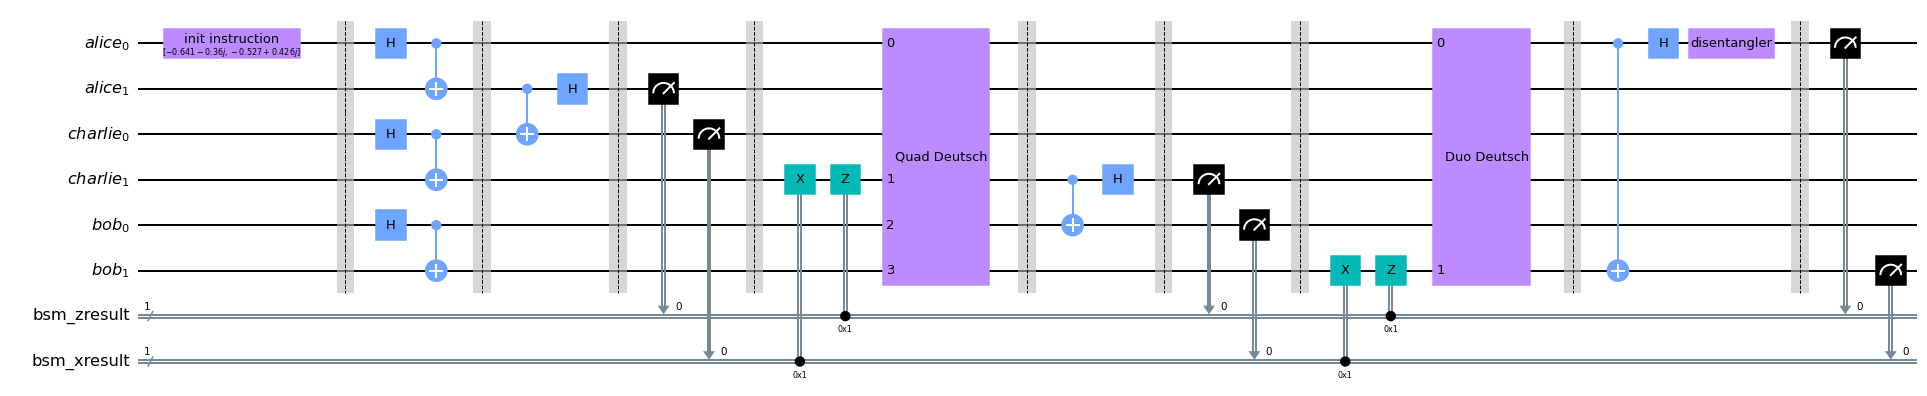

In [178]:
circ.draw("mpl", fold=-1)

### With Repeated Purification After Every Swap - Repeated Post Swap Purification

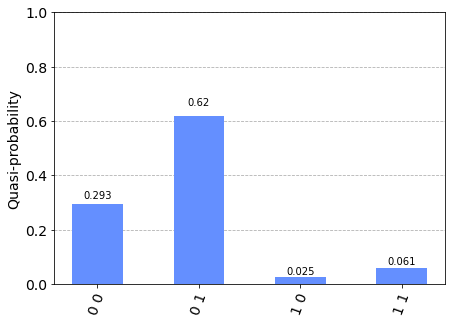

In [179]:
d = []
for i in range(ITERATIONS_TO_AVG):
    circ, counts = fidelity_analysis("swaploop")
    d.append(counts)

counts = dict( pd.DataFrame(d).mean() )

dict_fids_swaploop: dict = get_fidelities_dict(dict_counts)

graph = plot_histogram(counts)

dx = graph.axes[0]
dx.set_ylim(0, 1)

display( graph )

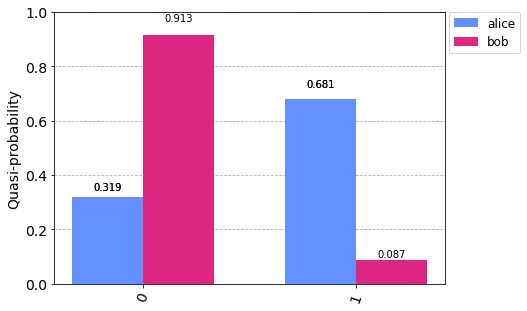

In [180]:
qubit_counts: list = [marginal_counts(counts, [qubit]) for qubit in range(0, 2)]
legend: list = ["alice", "bob"]
graph = plot_histogram(qubit_counts, legend=legend)#, title="Verification of Entanglement Swapping between Alice and Bob")
dx = graph.axes[0]
dx.set_ylim(0, 1)
display( graph )

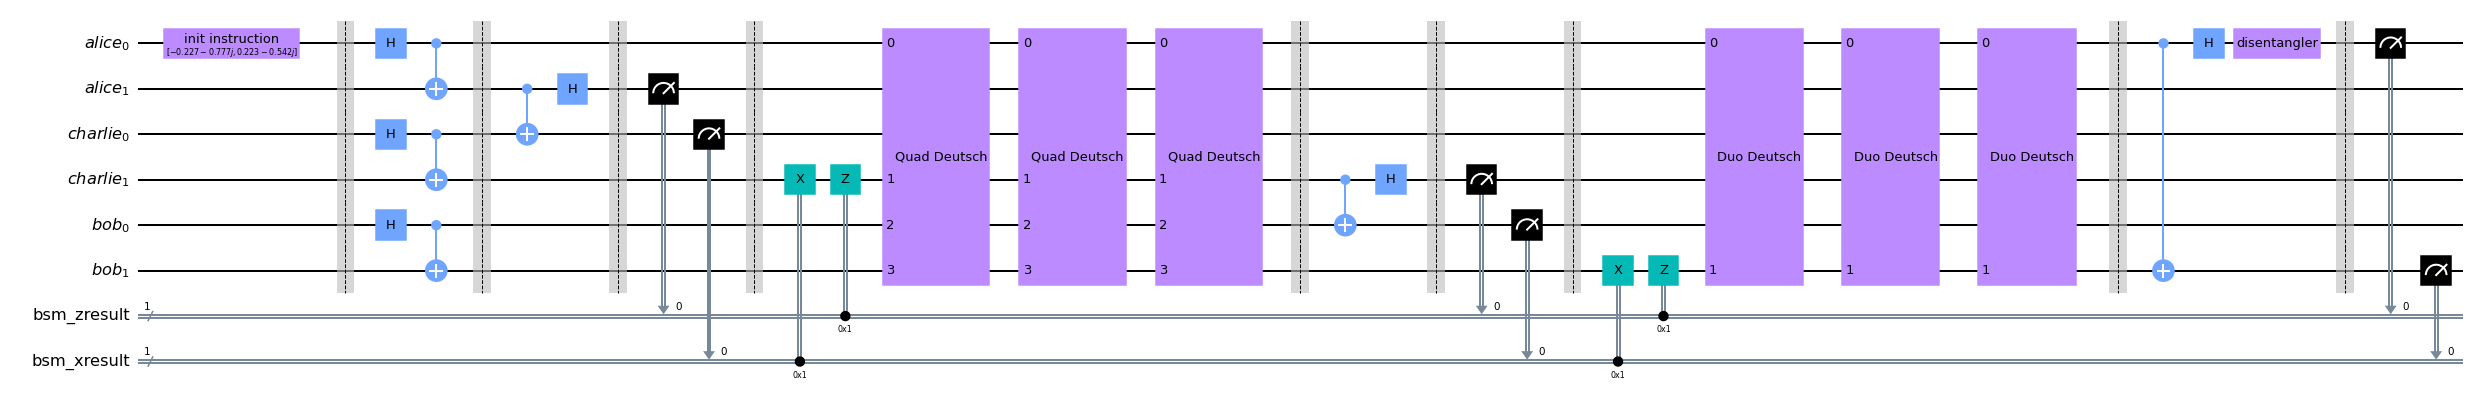

In [181]:
circ.draw("mpl", fold=-1)

### With Purification Before and After Every Swap - Alternating Purification Protocols - Pre and Post Swap Purification

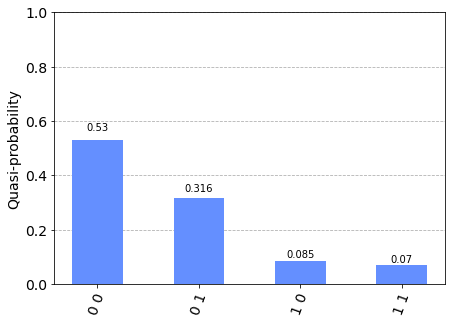

In [182]:
d = []
for i in range(ITERATIONS_TO_AVG):
    circ, counts = fidelity_analysis("swapalt")
    d.append(counts)

counts = dict( pd.DataFrame(d).mean() )

dict_fids_swapalt: dict = get_fidelities_dict(dict_counts)

graph = plot_histogram(counts)

dx = graph.axes[0]
dx.set_ylim(0, 1)

display( graph )

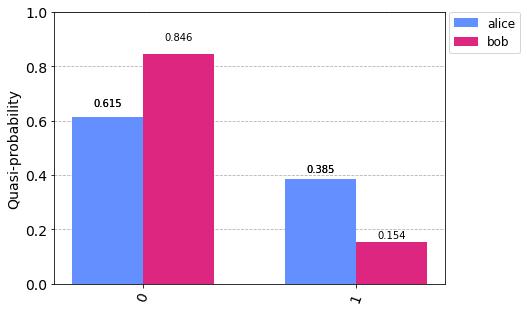

In [183]:
qubit_counts: list = [marginal_counts(counts, [qubit]) for qubit in range(0, 2)]
legend: list = ["alice", "bob"]
graph = plot_histogram(qubit_counts, legend=legend)#, title="Verification of Entanglement Swapping between Alice and Bob")
dx = graph.axes[0]
dx.set_ylim(0, 1)
display( graph )

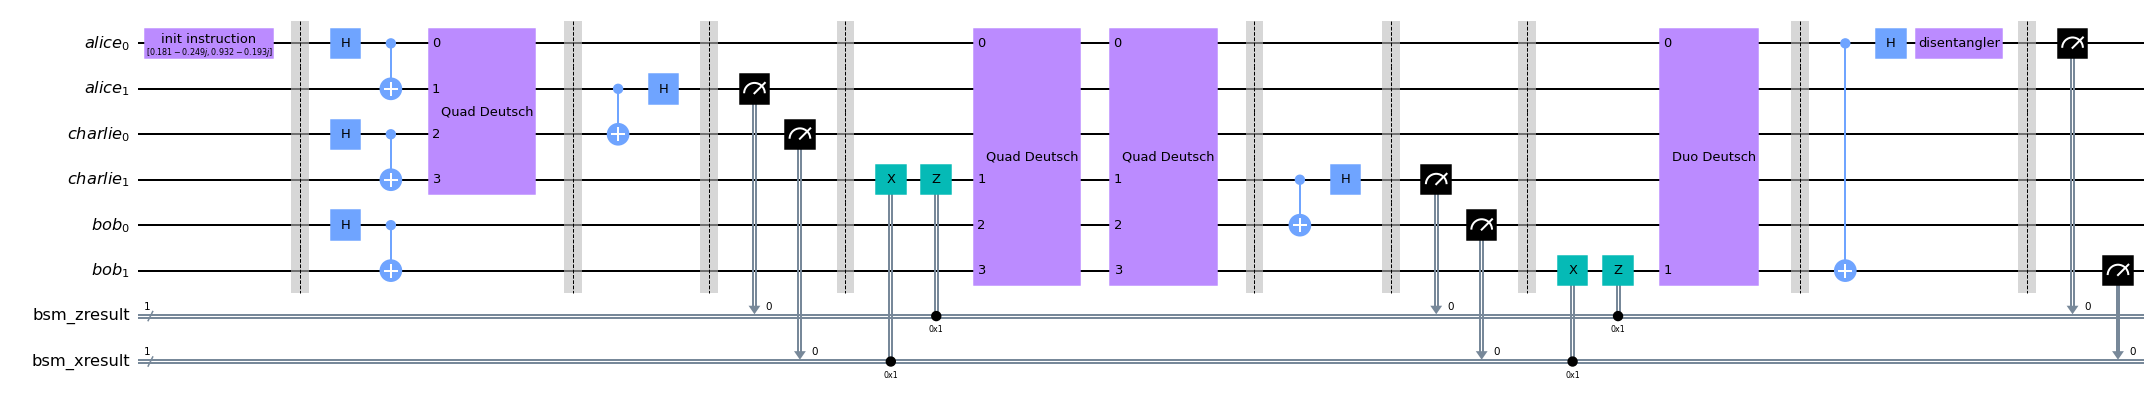

In [184]:
circ.draw("mpl", fold=-1)

### Suitable Purification Strategy - Custom Solution

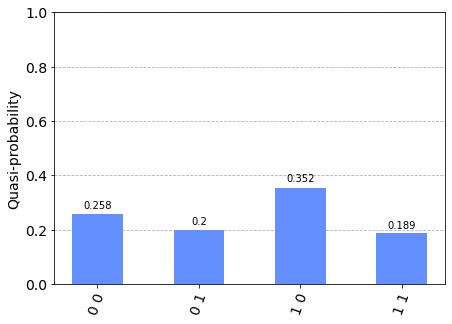

In [185]:
d = []
for i in range(ITERATIONS_TO_AVG):
    circ, counts = fidelity_analysis("cust")
    d.append(counts)

counts = dict( pd.DataFrame(d).mean() )

dict_fids_swapcust: dict = get_fidelities_dict(dict_counts)

graph = plot_histogram(counts)

dx = graph.axes[0]
dx.set_ylim(0, 1)

display( graph )

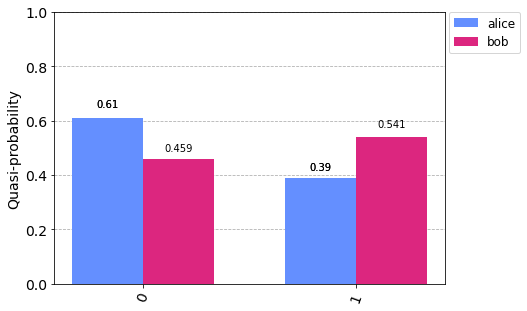

In [186]:
qubit_counts: list = [marginal_counts(counts, [qubit]) for qubit in range(0, 2)]
legend: list = ["alice", "bob"]
graph = plot_histogram(qubit_counts, legend=legend)#, title="Verification of Entanglement Swapping between Alice and Bob")
dx = graph.axes[0]
dx.set_ylim(0, 1)
display( graph )

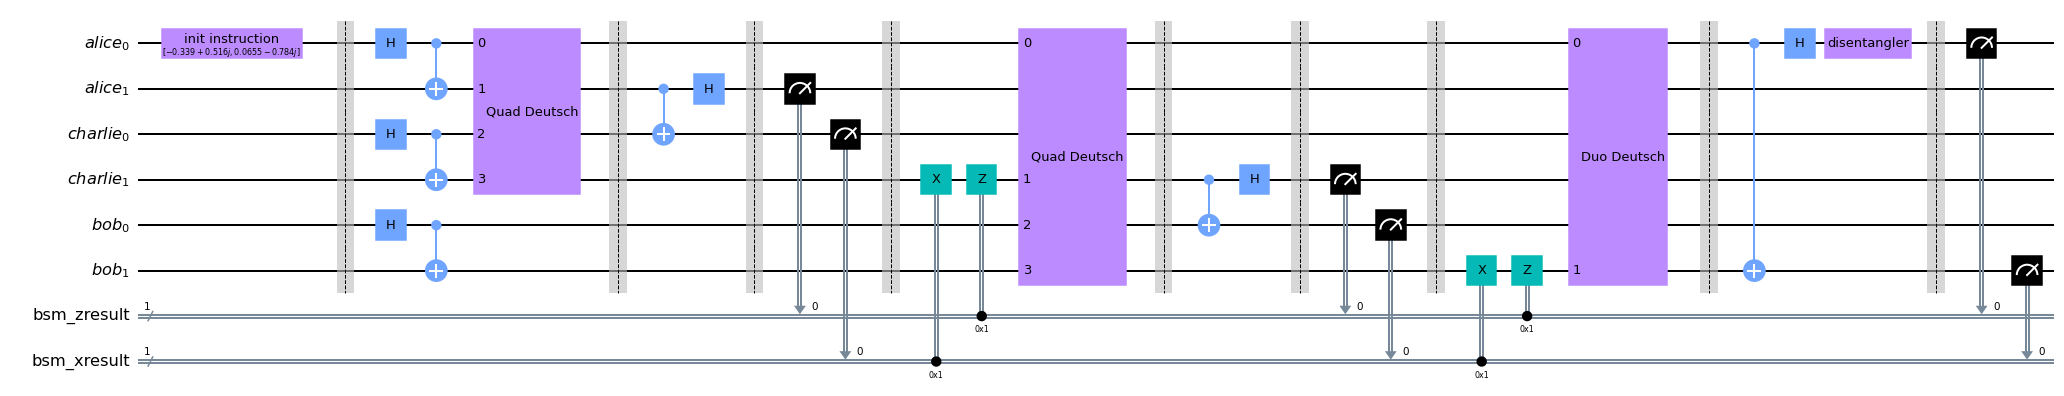

In [187]:
circ.draw("mpl", fold=-1)

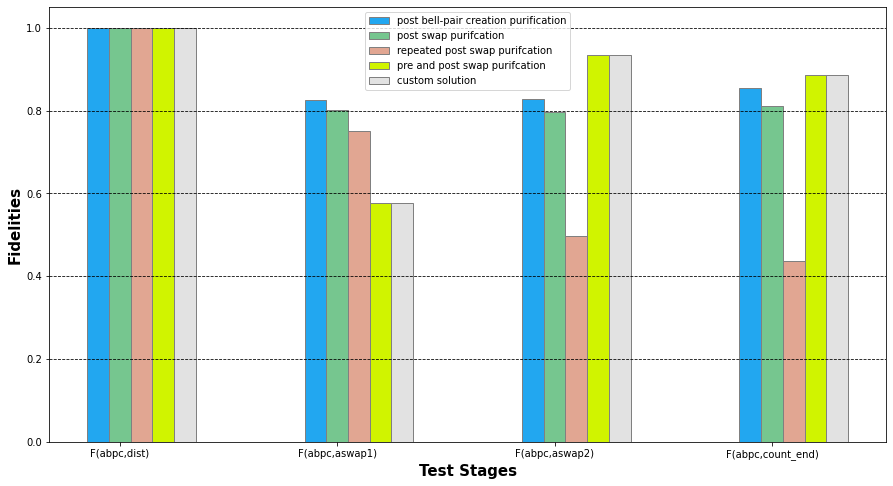

In [188]:
barwidth = 0.10
# fig = plt.figure(figsize = (10, 5))
fig = plt.subplots(figsize =(15, 8))

x_axis = np.arange(len(dict_fids_wp))

#1984c5", "#22a7f0", "#63bff0", "#a7d5ed", "#e2e2e2", "#e1a692", "#de6e56", "#e14b31", "#c23728"]
#115f9a", "#1984c5", "#22a7f0", "#48b5c4", "#76c68f", "#a6d75b", "#c9e52f", "#d0ee11", "#d0f400"]


# without purification
# x = list(dict_fids_wp.keys())
# y = list(dict_fids_wp.values())
# plt.bar(x_axis, y, width=barwidth, color="#115f9a", edgecolor="grey", label="without purifcation")

# with purification after bell pair creation
x = list(dict_fids_abpc.keys())
y = list(dict_fids_abpc.values())
plt.bar( x_axis, y, width=barwidth, color="#22a7f0", edgecolor="grey", label="post bell-pair creation purification")

# with purification after every swap
x = list(dict_fids_swap.keys())
y = list(dict_fids_swap.values())
plt.bar( [k + 1*barwidth for k in x_axis], y, width=barwidth, color="#76c68f", edgecolor="grey", label="post swap purifcation")

# with repeated purification after every swap
x = list(dict_fids_swaploop.keys())
y = list(dict_fids_swaploop.values())
plt.bar( [k + 2*barwidth for k in x_axis], y, width=barwidth, color="#e1a692", edgecolor="grey", label="repeated post swap purifcation")

# with alternating purification with every swap
x = list(dict_fids_swapalt.keys())
y = list(dict_fids_swapalt.values())
plt.bar( [k + 3*barwidth for k in x_axis], y, width=barwidth, color="#d0f400", edgecolor="grey", label="pre and post swap purifcation")

# suitable purifcation strategy
x = list(dict_fids_swapalt.keys())
y = list(dict_fids_swapalt.values())
plt.bar( [k + 4*barwidth for k in x_axis], y, width=barwidth, color="#e2e2e2", edgecolor="grey", label="custom solution")

plt.grid(visible=True, axis="y", linestyle="--", color="black")
plt.ylabel("Fidelities", fontweight="bold", fontsize=15)
plt.xlabel("Test Stages", fontweight="bold", fontsize=15)
plt.xticks(x_axis, list(dict_fids_wp.keys()))
plt.xticks( [k + barwidth for k in range(len(dict_fids_wp))], list(dict_fids_wp.keys()) )

# plt.title("The Impact of Purification on Fidelity at Specific Stages in a Quantum Repeater Protocol", fontweight="bold", fontsize=15)
plt.legend()
plt.show()